In [ ]:
# basin-paper-figures.ipynb
#
# Bryan Daniels
# 2024/1/24
#
# Minimal code for producing figures in the basin control approximation paper.
#
# Taking code from cell-collective-find-isolated-attractors.ipynb
# and basin-sizes-to-control-kernel-sizes.ipynb

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from toolbox.simplePickle import load,save
from toolbox.defaultFigure import makePretty
from load_control_kernel_data import loadDataExact

# recomputing basin data from scratch uses these packages
import tqdm
import networkx as nx
from neet.boolean import LogicNetwork,WTNetwork
from preimages import isolated_list
from cellCollective import load_all_cell_collective_networks

#import scipy.stats

In [2]:
from cellCollective import load_all_cell_collective_networks
from iowaDatabase import load_all_iowa_database_networks
from preimages import leaf_nodes,core_nodes,self_loop_input_nodes,isolated_list,preimages

In [3]:
# color palettes from coolors.co
colors1 = {'random':'#74D3AE',
           'random dark':'#2C8C67',
           'cellcollective':'#DD9787',
           'cellcollective dark':'#AF4831',
           'other':'#678D58'
          }

In [4]:
# useful code for dealing with cell collective networks from from code/cellCollective.py
def directory_name(n_name):
    """
    Returns the name of the Cell Collective directory given
    the "nice" name with spaces
    """
    return n_name.replace(' ','_').replace('.','')
    
def nice_name(dir_name):
    """
    Returns the "nice" name of the Cell Collective network
    given the directory name
    """
    nice = dir_name.replace('_',' ')
    if nice == 'Iron Acquisition And Oxidative Stress Response In Aspergillus Fumigatus':
        nice = nice+'.'
    return nice

# Load data

### Load data for random networks

In [5]:
dataDir = '/Users/bdaniel6/ASUDropbox/Shared/GRNs/DATA/'
dataDirRBN = dataDir+'20201215-control-kernels-rbn/'
dataDirRandom = dataDir+'20201211-control-kernels-random/'
dataDictExactRBN,dfExactRBN = loadDataExact(dataDirRBN,require_ck=True)
dataDictExactRandom,dfExactRandom = loadDataExact(dataDirRandom,require_ck=True)

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-p

In [6]:
# combine the two random ensembles
dfExactRandomAll = pd.concat([dfExactRBN,dfExactRandom])

In [7]:
print("Of {} loaded random networks, we have control kernel data for {} of them, and {} of these have at least one controllable attractor.".format(
    len(dfExactRandomAll),
    len(dfExactRandomAll[~dfExactRandomAll['control kernel time'].isna()]),
    len(dfExactRandomAll[dfExactRandomAll['number of attractors with control kernel']>0])))

Of 371 loaded random networks, we have control kernel data for 371 of them, and 350 of these have at least one controllable attractor.


### Load Iowa database control kernel data

In [8]:
iowaDataDir = '/Users/bdaniel6/ASUDropbox/Research/control-continuous/Data/240203-control-kernels/'
dataDictIowa,dfIowa = loadDataExact(iowaDataDir)

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Compute basin data for random networks (or load from file)

In [9]:
# takes about 25 minutes to compute everything here
recompute_WT_basins = False
recompute_RBN_basins = False
core_only = True

# compute for random weight-threshold networks
basinDataExactRandom = {}
for name in dataDictExactRandom:
    CKdata = dataDictExactRandom[name]
    weights = CKdata['net_weights']
    thresholds = CKdata['net_thresholds']
    net = WTNetwork(weights,thresholds=thresholds)
    connected_components = list(nx.connected_components(net.network_graph().to_undirected()))
    dfExactRandomAll.loc[name,'number of core nodes'] = len(core_nodes(net))
    dfExactRandomAll.loc[name,'number of input nodes'] = len(self_loop_input_nodes(net))
    if recompute_WT_basins: 
        basinDataExactRandom[name] = {
                                      'connected_components':connected_components,
                                      'basin_sizes':net.basin_sizes,
                                      'attractors':net.attractors,
                                     }
        if core_only:
            if len(leaf_nodes(net)) > 0:
                basinDataExactRandom[name]['isolated_list_core_only'] = isolated_list(net,net.attractors,core_only=True)
            else: # if there are no leaf nodes, we already know which basins are isolated
                basinDataExactRandom[name]['isolated_list_core_only'] = [ size==1 for size in net.basin_sizes ]
if recompute_WT_basins:
    if core_only:
        save(basinDataExactRandom,'240216_basinDataExactRandom_isolated_core_only.pkl')
    else:
        save(basinDataExactRandom,'240216_basinDataExactRandom.pkl')
else:
    if core_only: 
        basinDataExactRandom = load('240216_basinDataExactRandom_isolated_core_only.pkl') 
    else:
        basinDataExactRandom = load('240216_basinDataExactRandom.pkl')
    

# compute for "RBN" random networks
basinDataExactRBN = {}
for name in dataDictExactRBN: #tqdm.tqdm(dataDictExactRBN):
    CKdata = dataDictExactRBN[name]
    table = CKdata['net_table']
    net = LogicNetwork(table)
    connected_components = list(nx.connected_components(net.network_graph().to_undirected()))
    dfExactRandomAll.loc[name,'number of core nodes'] = len(core_nodes(net))
    dfExactRandomAll.loc[name,'number of input nodes'] = len(self_loop_input_nodes(net))
    if recompute_RBN_basins: 
        basinDataExactRBN[name] = {'basin_sizes':net.basin_sizes,
                                   'attractors':net.attractors,
                                   'connected_components':connected_components,
                                  }
        if core_only:
            if len(leaf_nodes(net)) > 0:
                basinDataExactRBN[name]['isolated_list_core_only'] = isolated_list(net,net.attractors,core_only=True)
            else: # if there are no leaf nodes, we already know which basins are isolated
                basinDataExactRBN[name]['isolated_list_core_only'] = [ size==1 for size in net.basin_sizes ]
if recompute_RBN_basins:
    if core_only:
        save(basinDataExactRBN,'240216_basinDataExactRBN_isolated_core_only.pkl')
    else:
        save(basinDataExactRBN,'240216_basinDataExactRBN.pkl')
else:
    if core_only:
        basinDataExactRBN = load('240216_basinDataExactRBN_isolated_core_only.pkl')
    else:
        basinDataExactRBN = load('240216_basinDataExactRBN.pkl')

### Save number of connected components for random networks

In [10]:
for basinDataExact in [basinDataExactRandom,basinDataExactRBN]:
    for name in basinDataExact:
        if name in dfExactRandomAll.index:
            dfExactRandomAll.loc[name,'number of connected components'] = len(basinDataExact[name]['connected_components'])

In [11]:
print("There are {} disconnected random networks out of {}.".format(
    len(dfExactRandomAll[dfExactRandomAll['number of connected components']>1]),
    len(dfExactRandomAll)))

There are 36 disconnected random networks out of 371.


### Load sampled basin data for cell collective networks

In [12]:
# gather all cell collective basin data into a dictionary
basindatadir = './'

basinDataDict = {}
for filename in glob.glob(basindatadir+'basin_entropy_data*.pkl'):
    data = load(filename)
    basinDataDict[data['name']] = data
# if "with_isolated" file exists, it is the more up-to-date file
for filename in glob.glob(basindatadir+'basin_entropy_data*_with_isolated.pkl'):
    data = load(filename)
    basinDataDict[data['name']] = data

### Compute basin data for cell collective networks (or load from file)

In [13]:
# compute isolated fixed points (or load from files)
# (recomputing everything here takes about 45 minutes --- or 20 minutes for core_only=True)
recompute_all = False
recompute_unfinished = False
core_only = True

if recompute_unfinished or recompute_all:
    cellCollectiveDir = '/Users/bdaniel6/ASUDropbox/Research/control-continuous/Data/Cell Collective/'
    netDict = load_all_cell_collective_networks(cellCollectiveDir)
    for net_name in basinDataDict:
        if recompute_all or (recompute_unfinished and ('is_isolated_list' not in basinDataDict[net_name])):
            print("Computing for network {}...".format(net_name))
            net = netDict[net_name]
            if ('sampled_basin_freqs' in basinDataDict[net_name]) and not core_only:
                is_isolated_list = isolated_list(net,
                                                 basinDataDict[net_name]['attractors'],
                                                 basinDataDict[net_name]['sampled_basin_freqs'],
                                                 use_louvain_communities=True,
                                                 core_only=core_only)
            else:
                is_isolated_list = isolated_list(net,
                                                 basinDataDict[net_name]['attractors'],
                                                 core_only=core_only)
            basinDataDict[net_name]['is_isolated_list'] = is_isolated_list
    # save basin data dictionaries
    for name in basinDataDict:
        if core_only:
            save(basinDataDict[name],'{}basin_entropy_data_{}_with_isolated_core.pkl'.format(basindatadir,name))
        else:
            save(basinDataDict[name],'{}basin_entropy_data_{}_with_isolated.pkl'.format(basindatadir,name))
else:
    # load basin data dictionaries with isolated fixed point data
    for net_name in basinDataDict:
        if core_only:
            basinDataDict[net_name] = load('{}basin_entropy_data_{}_with_isolated_core.pkl'.format(basindatadir,net_name))
        else:
            basinDataDict[net_name] = load('{}basin_entropy_data_{}_with_isolated.pkl'.format(basindatadir,net_name))

### Load basin data for Iowa database networks

In [14]:
core_only = True
if core_only:
    basinDataExactIowa = load('240216_basinDataIowa_core_only.pkl')
else:
    basinDataExactIowa = load('240209_basinDataIowa.pkl')

In [15]:
# compute number of isolated fixed points for each network
for net_name in basinDataExactIowa:
    if 'is_isolated_list' in basinDataExactIowa[net_name]:
        dfIowa.loc[net_name,'number of isolated fixed points'] = \
            np.sum(basinDataExactIowa[net_name]['is_isolated_list'])

### Load control kernel data for cell collective networks

In [16]:
control_kernel_data_file = '/Users/bdaniel6/ASUDropbox/Research/grn-survey/Writeups/control-kernel-2020/'\
    'Nature Comm final revision Aug 2021/zenodo Aug 2021/20200820_control_kernel_supplemental_info.csv'
ck_df = pd.read_csv(control_kernel_data_file).set_index('name')

# # include expected average ck size and difference from expected
# ck_df['expected mean control kernel size'] = np.log2(ck_df['number of attractors'])
# ck_df['difference from expected mean control kernel size'] = \
#     ck_df['mean control kernel size'] - ck_df['expected mean control kernel size']

# filter out cases for which we only have sampled control kernels
print("We filter out {} networks for which we only have sampled attractors:".format(ck_df['uses sampling method'].sum()))
for name in ck_df[ck_df['uses sampling method']].index:
     print(" - {}".format(name))
ck_df = ck_df[~ck_df['uses sampling method']]

print()
print("This leaves us with {} cell collective networks for which we have exact control kernel data.".format(len(ck_df)))

We filter out 5 networks for which we only have sampled attractors:
 - FA BRCA Pathway
 - Lymphoid And Myeloid Cell Specification And Transdifferentiation
 - Bordetella Bronchiseptica
 - Cholesterol Regulatory Pathway
 - Pc12 Cell Differentiation

This leaves us with 44 cell collective networks for which we have exact control kernel data.


In [17]:
# compute number of isolated fixed points for each network
for net_name in basinDataDict:
    if 'is_isolated_list' in basinDataDict[net_name]:
        ck_df.loc[nice_name(net_name),'number of isolated fixed points'] = \
            np.sum(basinDataDict[net_name]['is_isolated_list'])

In [18]:
print("We have isolated fixed point data for {} networks.".format(ck_df['number of isolated fixed points'].count()))

We have isolated fixed point data for 44 networks.


In [19]:
exactDataDir = '/Users/bdaniel6/ASUDropbox/Shared/GRNs/DATA/20200820-control-kernels/'
dataDictExact = loadDataExact(exactDataDir)[0]

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Calculate numbers of core nodes for biological networks

In [20]:
# TO DO: Save this info somewhere so we don't have to load all the networks every time

In [21]:
netDict = load_all_cell_collective_networks('../../Data/Cell Collective/')
netDictIowa = load_all_iowa_database_networks('../../Data/240202/models/update_rules_models_in_literature_we_randomly_come_across/')

In [22]:
# compute numbers of leaf and core nodes

for name in netDict:
    if nice_name(name) in ck_df.index:
        ck_df.loc[nice_name(name),'number of leaf nodes'] = len(leaf_nodes(netDict[name]))
        ck_df.loc[nice_name(name),'number of core nodes'] = len(core_nodes(netDict[name]))
        ck_df.loc[nice_name(name),'number of input nodes'] = len(self_loop_input_nodes(netDict[name]))

for name in netDictIowa:
    if name in dfIowa.index:
        dfIowa.loc[name,'number of leaf nodes'] = len(leaf_nodes(netDictIowa[name]))
        dfIowa.loc[name,'number of core nodes'] = len(core_nodes(netDictIowa[name]))
        dfIowa.loc[name,'number of input nodes'] = len(self_loop_input_nodes(netDictIowa[name]))

### Compute control kernel size predictions

In [23]:
# define functions for estimating average control kernel size

core_only_bio = True
core_only_random = True
core_only_RBN = True

# just log2(r)
def predict_ck_simple(basin_sizes,n):
    num_attractors = len(basin_sizes)
    return np.log2(num_attractors)

def predict_ck_all_basins(basin_sizes,n):
    return np.mean(n - np.log2(basin_sizes))

# n when basin size is <=1, log2(r) otherwise
def predict_ck_separate_isolated(basin_sizes,n):
    num_attractors = len(basin_sizes)
    num_unstable = np.sum(np.array(basin_sizes)<=1)
    return np.log2(num_attractors) + (n-np.log2(num_attractors))*num_unstable/num_attractors

def proportion_of_isolated_fixed_points(basin_sizes,n):
    return np.mean([ size == 1 for size in basin_sizes ])


# calculate the predicted mean control kernel sizes and store them in dataframes
functions_to_test = [predict_ck_simple,
                     predict_ck_separate_isolated,
                     proportion_of_isolated_fixed_points,
                     predict_ck_all_basins,
                    ]
for ck_func in functions_to_test: 
    
    # cell collective networks  
    ck_df[ck_func.__name__] = np.nan*np.zeros(len(ck_df))
    for name in basinDataDict.keys():
        #basin_samples = basinDataDict[name]['sampled_basin_freqs']
        # just convert Boolean value to 2 if non-isolated and 1 if isolated
        if 'is_isolated_list' in basinDataDict[name]:
            basin_sizes = 2-np.array(basinDataDict[name]['is_isolated_list'])
            if core_only_bio:
                n = ck_df.loc[nice_name(name),'number of core nodes']
            else:
                n = basinDataDict[name]['network_size']
            predicted_CK = ck_func(basin_sizes,n)
            ck_df.loc[nice_name(name),ck_func.__name__] = predicted_CK
        else:
            #pass
            print("No data for {}".format(name))

    # iowa database networks
    dfIowa[ck_func.__name__] = np.nan*np.zeros(len(dfIowa))
    for name in basinDataExactIowa.keys():
        if 'is_isolated_list' in basinDataExactIowa[name]:
            basin_sizes = 2-np.array(basinDataExactIowa[name]['is_isolated_list'])
            if core_only_bio:
                n = dfIowa.loc[name,'number of core nodes']
            else:
                n = dataDictIowa[name]['size']
            predicted_CK = ck_func(basin_sizes,n)
            dfIowa.loc[name,ck_func.__name__] = predicted_CK
        else:
            print("No data for {}".format(name))
    
    for name in basinDataExactRandom.keys(): 
        if core_only_random:
            # just convert Boolean value to 2 if non-isolated and 0 if isolated
            isolated_list_core_only = basinDataExactRandom[name]['isolated_list_core_only']
            basin_sizes = 2-np.array(isolated_list_core_only)
            n = dfExactRandomAll.loc[name,'number of core nodes']
        else:
            basin_sizes = basinDataExactRandom[name]['basin_sizes']
            n = dataDictExactRandom[name]['size']
        predicted_CK = ck_func(basin_sizes,n)
        dfExactRandomAll.loc[name,ck_func.__name__] = predicted_CK
        
    for name in basinDataExactRBN.keys():
        basin_sizes = basinDataExactRBN[name]['basin_sizes']
        if core_only_RBN:
            # just convert Boolean value to 2 if non-isolated and 1 if isolated
            isolated_list_core_only = basinDataExactRBN[name]['isolated_list_core_only']
            basin_sizes = 2-np.array(isolated_list_core_only)
            n = dfExactRandomAll.loc[name,'number of core nodes']
        else:
            basin_sizes = basinDataExactRandom[name]['basin_sizes']
            n = dataDictExactRBN[name]['size']
        predicted_CK = ck_func(basin_sizes,n)
        dfExactRandomAll.loc[name,ck_func.__name__] = predicted_CK

### Gather basin sizes and control kernel sizes for individual attractors of random networks

In [24]:
relative_basin_sizes = []
relative_ck_sizes_isolated = []
relative_ck_sizes_nonisolated = []
relative_ck_sizes_isolated_core_only = []
relative_ck_sizes_nonisolated_core_only = []
relative_ck_sizes_noloop = []
relative_ck_sizes_noloop_core_only = []
absolute_ck_sizes = []
net_sizes = []
for dataDict,basinDataExact in zip([dataDictExactRandom,dataDictExactRBN],
                                   [basinDataExactRandom,basinDataExactRBN]):
    for name in basinDataExact:
        if 'control_kernel_sizes' in dataDict[name]:
            # sort everything by the first state of each attractor
            ckAtts = dataDict[name]['attractors']
            basinAtts = basinDataExact[name]['attractors']
            ckOrder = np.argsort([ min(a) for a in ckAtts ])
            basinOrder = np.argsort([ min(a) for a in basinAtts ])
            
            ck_sizes = np.array(dataDict[name]['control_kernel_sizes'])[ckOrder]
            net_size = dataDict[name]['size']
            net_core_size = dfExactRandomAll.loc[name,'number of core nodes']
            net_num_inputs = dfExactRandomAll.loc[name,'number of input nodes']
            basin_sizes = np.array(basinDataExact[name]['basin_sizes'])[basinOrder]
            isolated = [ basin_size==1 for basin_size in basin_sizes ]
            isolated_core_only = np.array(basinDataExact[name]['isolated_list_core_only'])[basinOrder]
            basinDataExact[name]['control_kernel_sizes_ordered'] = ck_sizes
            basinDataExact[name]['is_isolated_list_ordered'] = isolated
            basinDataExact[name]['is_isolated_list_core_only_ordered'] = isolated_core_only

            # save control kernel sizes filtered to include only nonisolated attractors
            ck_sizes_nonisolated = [ ck_sizes[i] for i in range(len(ck_sizes)) if not isolated[i] ]
            basinDataExact[name]['control_kernel_sizes_nonisolated'] = ck_sizes_nonisolated
            dfExactRandomAll.loc[name,'mean control kernel size nonisolated'] = \
                np.mean([ ck_size for ck_size in ck_sizes_nonisolated if ck_size is not None ])
            
            # add to lists of isolated and nonisolated relative ck sizes
            relative_basin_sizes.extend( [ basin_sizes[i]/(2**net_size) for i in range(len(ck_sizes)) \
                  if (ck_sizes[i] is not None) ])
            if net_num_inputs == net_core_size: # keep data from zero-loop networks separate
                relative_ck_sizes_noloop.extend(
                    [ ck_sizes[i]/net_size for i in range(len(ck_sizes)) \
                      if (ck_sizes[i] is not None) ])
                relative_ck_sizes_noloop_core_only.extend(
                    [ ck_sizes[i]/net_core_size for i in range(len(ck_sizes)) \
                      if (ck_sizes[i] is not None) ])
            else:
                relative_ck_sizes_isolated.extend(
                    [ ck_sizes[i]/net_size for i in range(len(ck_sizes)) \
                      if isolated[i] and (ck_sizes[i] is not None) ])
                relative_ck_sizes_nonisolated.extend(
                    [ ck_sizes[i]/net_size for i in range(len(ck_sizes)) \
                      if (not isolated[i]) and (ck_sizes[i] is not None) ])
                relative_ck_sizes_isolated_core_only.extend(
                    [ ck_sizes[i]/net_core_size for i in range(len(ck_sizes)) \
                      if isolated_core_only[i] and (ck_sizes[i] is not None) ])
                relative_ck_sizes_nonisolated_core_only.extend(
                    [ ck_sizes[i]/net_core_size for i in range(len(ck_sizes)) \
                      if (not isolated_core_only[i]) and (ck_sizes[i] is not None) ])
            absolute_ck_sizes.extend([ ck_sizes[i] for i in range(len(ck_sizes)) \
                  if (ck_sizes[i] is not None) ])
            net_sizes.extend( [ net_size for i in range(len(ck_sizes)) \
                  if (ck_sizes[i] is not None) ])
        else:
            pass
            #print("No control kernel data for network {}.".format(name))

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Gather basin sizes and control kernel sizes for individual attractors of cell collective networks

In [25]:
relative_ck_sizes_isolated_cc = []
relative_ck_sizes_nonisolated_cc = []
relative_ck_sizes_isolated_core_only_cc = []
relative_ck_sizes_nonisolated_core_only_cc = []
relative_ck_sizes_noloop_cc = []
relative_ck_sizes_noloop_core_only_cc = []
for name in basinDataDict:
    ck_sizes = dataDictExact[nice_name(name)]['control_kernel_sizes']
    basinDataDict[name]['control_kernel_sizes'] = ck_sizes
    net_size = basinDataDict[name]['network_size']
    net_core_size = ck_df.loc[nice_name(name),'number of core nodes']
    net_num_inputs = ck_df.loc[nice_name(name),'number of input nodes']
    if 'is_isolated_list' in basinDataDict[name]: # already uses only core nodes when core_only = True above
        isolated = basinDataDict[name]['is_isolated_list']
        
        # save control kernel sizes filtered to include only nonisolated attractors
        ck_sizes_nonisolated = [ ck_sizes[i] for i in range(len(ck_sizes)) if not isolated[i] ]
        basinDataDict[name]['control_kernel_sizes_nonisolated'] = ck_sizes_nonisolated
        ck_df.loc[nice_name(name),'mean control kernel size nonisolated'] = \
            np.mean([ ck_size for ck_size in ck_sizes_nonisolated if ck_size is not None ])

         # add to lists of isolated and nonisolated relative ck sizes
        if net_num_inputs == net_core_size: # keep data from zero-loop networks separate
            relative_ck_sizes_noloop_cc.extend(
                [ ck_sizes[i]/net_size for i in range(len(ck_sizes)) if (ck_sizes[i] != None)])
            relative_ck_sizes_noloop_core_only_cc.extend(
                [ ck_sizes[i]/net_core_size for i in range(len(ck_sizes)) if (ck_sizes[i] != None) ])
        else:
            relative_ck_sizes_isolated_cc.extend([ ck_sizes[i]/net_size for i in range(len(ck_sizes)) if isolated[i] ])
            relative_ck_sizes_nonisolated_cc.extend(
                [ ck_sizes[i]/net_size for i in range(len(ck_sizes)) if (not isolated[i]) and (ck_sizes[i] is not None) ])        
            relative_ck_sizes_isolated_core_only_cc.extend([ ck_sizes[i]/net_core_size for i in range(len(ck_sizes)) if isolated[i] ])
            relative_ck_sizes_nonisolated_core_only_cc.extend(
                [ ck_sizes[i]/net_core_size for i in range(len(ck_sizes)) if (not isolated[i]) and (ck_sizes[i] is not None) ])    

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Gather basin sizes and control kernel sizes for individual attractors of Iowa database networks

In [26]:
relative_ck_sizes_isolated_iowa = []
relative_ck_sizes_nonisolated_iowa = []
relative_ck_sizes_isolated_core_only_iowa = []
relative_ck_sizes_nonisolated_core_only_iowa = []
relative_ck_sizes_noloop_iowa = []
relative_ck_sizes_noloop_core_only_iowa = []
for name in basinDataExactIowa:
    ck_sizes = dataDictIowa[name]['control_kernel_sizes']
    basinDataExactIowa[name]['control_kernel_sizes'] = ck_sizes
    net_size = dataDictIowa[name]['size']
    net_core_size = dfIowa.loc[name,'number of core nodes']
    net_num_inputs = dfIowa.loc[name,'number of input nodes']
    if 'is_isolated_list' in basinDataExactIowa[name]:
        isolated = basinDataExactIowa[name]['is_isolated_list']
        
        # save control kernel sizes filtered to include only nonisolated attractors
        # ck_sizes_nonisolated = [ ck_sizes[i] for i in range(len(ck_sizes)) if not isolated[i] ]
        # basinDataExactIowa[name]['control_kernel_sizes_nonisolated'] = ck_sizes_nonisolated
        # dfIowa.loc[name,'mean control kernel size nonisolated'] = \
        #     np.mean([ ck_size for ck_size in ck_sizes_nonisolated if ck_size is not None ])

        # add to lists of isolated and nonisolated relative ck sizes
        if net_num_inputs == net_core_size: # keep data from zero-loop networks separate
            relative_ck_sizes_noloop_iowa.extend(
                [ ck_sizes[i]/net_size for i in range(len(ck_sizes)) if (ck_sizes[i] != None) ])
            relative_ck_sizes_noloop_core_only_iowa.extend(
                [ ck_sizes[i]/net_core_size for i in range(len(ck_sizes)) if (ck_sizes[i] != None) ])
        else:
            relative_ck_sizes_isolated_iowa.extend([ ck_sizes[i]/net_size for i in range(len(ck_sizes)) if isolated[i] ])
            relative_ck_sizes_nonisolated_iowa.extend(
                [ ck_sizes[i]/net_size for i in range(len(ck_sizes)) if (not isolated[i]) and (ck_sizes[i] is not None) ])    
            relative_ck_sizes_isolated_core_only_iowa.extend([ ck_sizes[i]/net_core_size for i in range(len(ck_sizes)) if isolated[i] ])
            relative_ck_sizes_nonisolated_core_only_iowa.extend(
                [ ck_sizes[i]/net_core_size for i in range(len(ck_sizes)) if (not isolated[i]) and (ck_sizes[i] is not None) ])    

### Output relevant data for variance calculations

In [27]:
# save data for random networks
print("Including data for {} random networks.".format(len(dfExactRandomAll)))
dfExactRandomAll['number of isolated fixed points'] = \
    dfExactRandomAll['proportion_of_isolated_fixed_points'] * dfExactRandomAll['number of attractors']
columns_to_save = ['mean control kernel size',
                   'number of attractors',
                   'size',
                   'number of core nodes',
                   'number of isolated fixed points']
dfExactRandomAll[columns_to_save].to_csv('240216_random_ck_and_isolated_fp_data.csv')

# save data for cell collective networks
print("Including data for {} cell collective networks.".format(len(ck_df)))
ck_df[columns_to_save].to_csv('240216_cell_collective_ck_and_isolated_fp_data.csv')

# save data for iowa database networks
print("Including data for {} Iowa database networks.".format(len(dfIowa)))
dfIowa[columns_to_save].to_csv('240216_iowa_database_ck_and_isolated_fp_data.csv')

Including data for 371 random networks.
Including data for 44 cell collective networks.
Including data for 60 Iowa database networks.


### 2024/2/6 compute fraction of state space that leads to uncontrollable attractors

In [28]:
# compute fraction of uncontrollable states for random networks
for basinDict,dataDict in zip([basinDataExactRandom,basinDataExactRBN],[dataDictExactRandom,dataDictExactRBN]):
    for name in dataDict:
        if 'control_kernels' in dataDict[name]:
            is_uncontrollable_list = np.array([ ck==None for ck in dataDict[name]['control_kernels'] ])
            num_uncontrollable_states = np.sum([ np.array(basinDict[name]['basin_sizes'])*is_uncontrollable_list ])
            assert(np.sum(basinDict[name]['basin_sizes']) == 2**dataDict[name]['size'])
            num_total_states = 2**dataDict[name]['size']
            dfExactRandomAll.loc[name,'fraction of uncontrollable states'] = num_uncontrollable_states/num_total_states

# compute fraction of uncontrollable attractors for random networks
num_uncontrollable = dfExactRandomAll['number of attractors'] - dfExactRandomAll['number of attractors with control kernel']
dfExactRandomAll['fraction of uncontrollable attractors'] = num_uncontrollable/dfExactRandomAll['number of attractors']

In [29]:
# compute fraction of uncontrollable states for cell collective networks
for name in dataDictExact:
    if 'sampled_basin_freqs' in basinDataDict[directory_name(name)]:
        is_uncontrollable_list = np.array([ ck==None for ck in dataDictExact[name]['control_kernels'] ])
        num_uncontrollable_states = np.sum([ np.array(basinDataDict[directory_name(name)]['sampled_basin_freqs'])*is_uncontrollable_list ])
        #assert(np.sum(basinDataExact[name]['basin_sizes']) == 2**dataDict[name]['size'])
        num_total_states = 2**dataDictExact[name]['size']
        ck_df.loc[name,'fraction of uncontrollable states'] = num_uncontrollable_states/num_total_states
    else:
        print("No basin data for {}".format(name))

No basin data for Budding Yeast Cell Cycle 2009
No basin data for Arabidopsis Thaliana Cell Cycle
No basin data for Septation Initiation Network
No basin data for Tumour Cell Invasion And Migration
No basin data for Mammalian Cell Cycle 2006
No basin data for Treatment Of Castration-Resistant Prostate Cancer
No basin data for Guard Cell Abscisic Acid Signaling
No basin data for Fanconi Anemia And Checkpoint Recovery
No basin data for T-Cell Signaling 2006


Text(0.5, 0, 'Fraction of states leading to uncontrollable cycles')

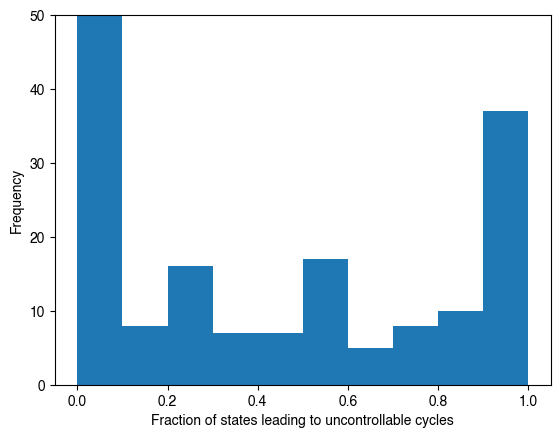

In [30]:
dfExactRandomAll['fraction of uncontrollable states'].plot.hist()
plt.axis(ymax=50)
plt.xlabel('Fraction of states leading to uncontrollable cycles')

<Axes: ylabel='Frequency'>

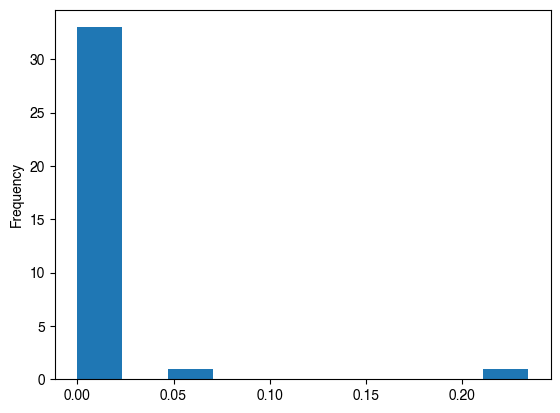

In [31]:
ck_df['fraction of uncontrollable states'].plot.hist()

### 2024/2/15 Considering leaf nodes

In [32]:
ck_df[ck_df['number of isolated fixed points']>0]['number of leaf nodes']

name
Toll Pathway Of Drosophila Signaling Pathway                       1.0
BT474 Breast Cell Line Short-term ErbB Network                     0.0
SKBR3 Breast Cell Line Short-term ErbB Network                     0.0
HCC1954 Breast Cell Line Short-term ErbB Network                   0.0
Vegf Pathway Of Drosophila Signaling Pathway                       1.0
FGF Pathway Of Drosophila Signalling Pathways                      1.0
TOL Regulatory Network                                             2.0
Processing Of Spz Network From The Drosophila Signaling Pathway    1.0
HH Pathway Of Drosophila Signaling Pathways                        1.0
BT474 Breast Cell Line Long-term ErbB Network                      0.0
SKBR3 Breast Cell Line Long-term ErbB Network                      0.0
HCC1954 Breast Cell Line Long-term ErbB Network                    0.0
Treatment Of Castration-Resistant Prostate Cancer                  6.0
Name: number of leaf nodes, dtype: float64

Text(0.5, 1.0, 'cell collective')

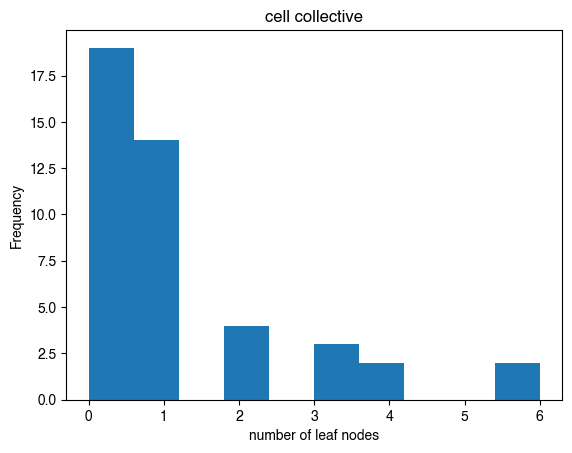

In [33]:
ck_df['number of leaf nodes'].plot.hist()
plt.xlabel('number of leaf nodes')
plt.title('cell collective')

In [34]:
print("{} of {} analyzed cell collective networks have leaf nodes.".format(len(ck_df[ck_df['number of leaf nodes']>0]),len(ck_df)))

25 of 44 analyzed cell collective networks have leaf nodes.


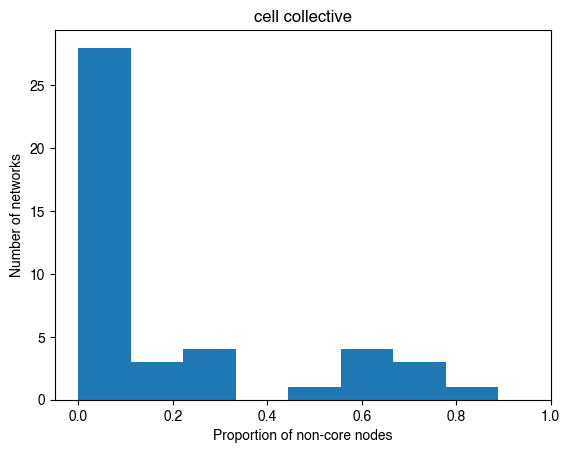

In [35]:
bins = np.linspace(0,1,10)
plt.hist((ck_df['size']-ck_df['number of core nodes'])/ck_df['size'],bins=bins)
plt.xlabel('Proportion of non-core nodes')
plt.ylabel('Number of networks')
plt.title('cell collective')
plt.axis(xmax=1);

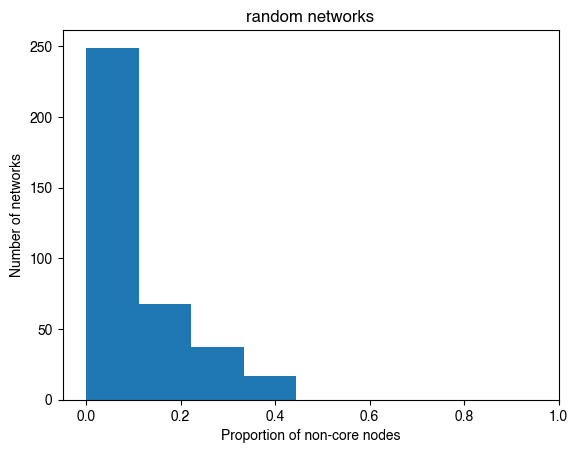

In [36]:
bins = np.linspace(0,1,10)
plt.hist((dfExactRandomAll['size']-dfExactRandomAll['number of core nodes'])/dfExactRandomAll['size'],bins=bins)
plt.xlabel('Proportion of non-core nodes')
plt.ylabel('Number of networks')
plt.title('random networks')
plt.axis(xmax=1);

# Make plots

### Average control kernel size prediction plots — random networks

In [37]:
minsize,maxsize = 0,20
markersize = 20
figsize = (3,2.5) #(5,4)
bottom,top,left,right = 0.2,0.95,0.2,0.95
uncontrollable_fraction_threshold = 0.99 #0.5

In [38]:
# filter based on uncontrollable fraction
dfExactRandomAll_Filtered = dfExactRandomAll[dfExactRandomAll['fraction of uncontrollable states']<uncontrollable_fraction_threshold].copy()
print("We remove {} random networks out of {} with proportion of states leading to uncontrollable attractors > {}.".format(
    len(dfExactRandomAll)-len(dfExactRandomAll_Filtered),len(dfExactRandomAll),uncontrollable_fraction_threshold))

We remove 25 random networks out of 371 with proportion of states leading to uncontrollable attractors > 0.99.


This plot includes points for 346 networks.
There are 87 networks out of 346 with proportion of isolated fixed points > 0.0.


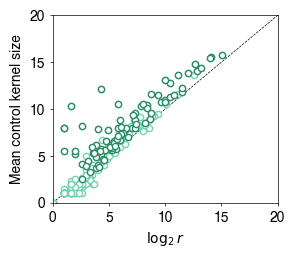

In [39]:
# plot control kernel size with respect to the number of attractors for random networks

plt.figure(figsize=figsize)
plt.scatter(np.log2(dfExactRandomAll_Filtered['number of attractors']),
            dfExactRandomAll_Filtered['mean control kernel size'],
            s=markersize,
            label='Actual CK size',
            c='w',
            edgecolors=colors1['random'])
print("This plot includes points for {} networks.".format(dfExactRandomAll_Filtered['mean control kernel size'].count()))

# highlight networks with large proportion of isolated fixed points
threshold = 0.0
dfExactRandomAll_largeProp = dfExactRandomAll_Filtered[dfExactRandomAll_Filtered['number of isolated fixed points'] > threshold]
plt.scatter(np.log2(dfExactRandomAll_largeProp['number of attractors']),
            dfExactRandomAll_largeProp['mean control kernel size'],
            s=markersize,
            label='Actual CK size',
            c='w',
            edgecolors=colors1['random dark'])
print("There are {} networks out of {} with proportion of isolated fixed points > {}.".format(
    len(dfExactRandomAll_largeProp),len(dfExactRandomAll_Filtered),threshold))

plt.xlabel('$\\log_2{r}$')
plt.ylabel('Mean control kernel size')
#plt.xscale('log')
plt.plot([minsize,maxsize],[minsize,maxsize],'k--',lw=0.5,zorder=-10)

plt.axis(xmin=minsize,xmax=maxsize,ymin=minsize,ymax=maxsize)
plt.yticks([0,5,10,15,20])
plt.subplots_adjust(bottom=bottom,top=top,left=left,right=right)
makePretty()
plt.savefig('240219_ck_size_vs_log2r_random.pdf')

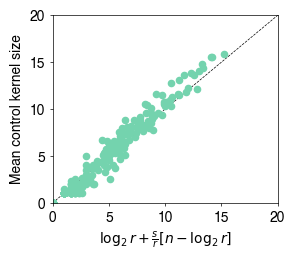

In [40]:
# plot actual ck size versus isolated approximation for random networks

plt.figure(figsize=figsize)
for ck_func in [predict_ck_separate_isolated,]:
    plt.scatter(dfExactRandomAll_Filtered[ck_func.__name__],
                dfExactRandomAll_Filtered['mean control kernel size'],
                label=ck_func.__name__,
                s=markersize,
                c=colors1['random']
                )

#plt.xlabel('$\\frac{r-s}{r} \log_2{r} + \\frac{s}{r} n$')
plt.xlabel('$\\log_2{r} + \\frac{s}{r} \\left[ n - \\log_2{r} \\right]$')
plt.ylabel('Mean control kernel size')
minsize,maxsize = 0,20
plt.plot([minsize,maxsize],[minsize,maxsize],'k--',lw=0.5,zorder=-10)
plt.axis(xmin=minsize,xmax=maxsize,ymin=minsize,ymax=maxsize)
plt.yticks([0,5,10,15,20])
plt.subplots_adjust(bottom=bottom,top=top,left=left,right=right)
#plt.legend()
makePretty()
plt.savefig('240219_actual_versus_predicted_mean_ck_size_random_networks.pdf')

### Average control kernel size prediction plots — cell collective networks

In [41]:
# filter based on uncontrollable fraction
print("There are {} cell collective networks with no data on uncontrollable fraction.".format(
    len(ck_df) - ck_df['fraction of uncontrollable states'].count()))

ck_df_Filtered = ck_df[((ck_df['fraction of uncontrollable states']<uncontrollable_fraction_threshold) | 
                       (ck_df['fraction of uncontrollable states'].isna())) & 
                       (ck_df['number of attractors with control kernel'] > 0)]
print("We remove {} cell collective networks out of {} with proportion of states leading to uncontrollable attractors > {}.".format(
    len(ck_df)-len(ck_df_Filtered),len(ck_df),uncontrollable_fraction_threshold))

print("We currently have no data on basin sizes in Iowa database networks, so we do not filter wrt uncontrollable attractors.")
dfIowa_Filtered = dfIowa[dfIowa['number of attractors with control kernel'] > 0]
print("We remove {} Iowa database networks out of {} with no controllable attractors.".format(
    len(dfIowa)-len(dfIowa_Filtered),len(dfIowa)))

print()
print("There are a total of {} biological networks with exact control kernel data, and {} networks after filtering.".format(
    len(dfIowa)+len(ck_df),len(dfIowa_Filtered)+len(ck_df_Filtered)
))

There are 9 cell collective networks with no data on uncontrollable fraction.
We remove 0 cell collective networks out of 44 with proportion of states leading to uncontrollable attractors > 0.99.
We currently have no data on basin sizes in Iowa database networks, so we do not filter wrt uncontrollable attractors.
We remove 7 Iowa database networks out of 60 with no controllable attractors.

There are a total of 104 biological networks with exact control kernel data, and 97 networks after filtering.


This plot includes points for 44 cell collective networks.
This plot includes points for 53 Iowa database networks.
There are 13 cell collective networks out of 44 with proportion of isolated fixed points > 0.0.
There are 4 Iowa database networks out of 53 with proportion of isolated fixed points > 0.0.


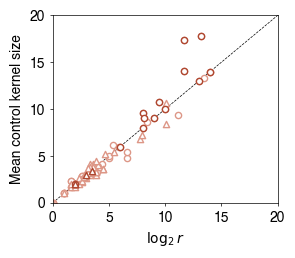

In [42]:
# plot control kernel size with respect to the number of attractors for biological networks

# cell collective 
plt.figure(figsize=figsize)
plt.scatter(np.log2(ck_df_Filtered['number of attractors']),
            ck_df_Filtered['mean control kernel size'],
            s=markersize,
            label='Actual CK size',
            edgecolors=colors1['cellcollective'],
            c='w')
print("This plot includes points for {} cell collective networks.".format(ck_df_Filtered['mean control kernel size'].count()))

# iowa database
plt.scatter(np.log2(dfIowa_Filtered['number of attractors']),
            dfIowa_Filtered['mean control kernel size'],
            s=markersize,
            label='Actual CK size',
            edgecolors=colors1['cellcollective'],
            c='w',
            marker='^')
print("This plot includes points for {} Iowa database networks.".format(dfIowa_Filtered['mean control kernel size'].count()))

# highlight networks with large proportion of isolated fixed points
threshold = 0.0
# cell collective
ck_df_largeProp = ck_df_Filtered[ck_df_Filtered['number of isolated fixed points'] > threshold]
plt.scatter(np.log2(ck_df_largeProp['number of attractors']),
            ck_df_largeProp['mean control kernel size'],
            s=markersize,
            label='Actual CK size',
            c='w',
            edgecolors=colors1['cellcollective dark'])
print("There are {} cell collective networks out of {} with proportion of isolated fixed points > {}.".format(
    len(ck_df_largeProp),len(ck_df_Filtered),threshold))
# iowa database
dfIowa_largeProp = dfIowa_Filtered[dfIowa_Filtered['number of isolated fixed points'] > threshold]
plt.scatter(np.log2(dfIowa_largeProp['number of attractors']),
            dfIowa_largeProp['mean control kernel size'],
            s=markersize,
            label='Actual CK size',
            c='w',
            edgecolors=colors1['cellcollective dark'],
            marker='^')
print("There are {} Iowa database networks out of {} with proportion of isolated fixed points > {}.".format(
    len(dfIowa_largeProp),len(dfIowa_Filtered),threshold))

plt.xlabel('$\\log_2{r}$')
plt.ylabel('Mean control kernel size')
#plt.xscale('log')
plt.plot([minsize,maxsize],[minsize,maxsize],'k--',lw=0.5,zorder=-10)
#plt.legend()
plt.axis(xmin=minsize,xmax=maxsize,ymin=minsize,ymax=maxsize)
plt.yticks([0,5,10,15,20])
plt.subplots_adjust(bottom=bottom,top=top,left=left,right=right)
makePretty()
plt.savefig('240219_ck_size_vs_log2r_cell_collective.pdf')

In [43]:
dfIowa_largeProp[['size','number of core nodes','number of input nodes','number of attractors','number of isolated fixed points']]

,size,number of core nodes,number of input nodes,number of attractors,number of isolated fixed points
name,,,,,
21450717_model_2_brassinosteroid,10,3.0,3.0,8,8.0
23764028,5,2.0,2.0,4,4.0
1753781,8,8.0,0.0,11,1.0
26346668,30,2.0,2.0,4,4.0


In [44]:
ck_df_largeProp[['size','number of core nodes','number of input nodes','number of attractors','number of isolated fixed points']]

,size,number of core nodes,number of input nodes,number of attractors,number of isolated fixed points
name,,,,,
Toll Pathway Of Drosophila Signaling Pathway,11,2.0,2,4,4.0
BT474 Breast Cell Line Short-term ErbB Network,16,16.0,5,253,24.0
SKBR3 Breast Cell Line Short-term ErbB Network,16,16.0,5,702,104.0
HCC1954 Breast Cell Line Short-term ErbB Network,16,16.0,5,274,10.0
Vegf Pathway Of Drosophila Signaling Pathway,18,8.0,8,256,256.0
FGF Pathway Of Drosophila Signalling Pathways,23,9.0,9,512,512.0
TOL Regulatory Network,24,10.0,10,1024,1024.0
Processing Of Spz Network From The Drosophila Signaling Pathway,24,6.0,6,64,64.0
HH Pathway Of Drosophila Signaling Pathways,24,13.0,13,8192,8192.0


This plot includes points for 44 cell collective networks.
This plot includes points for 53 Iowa database networks.


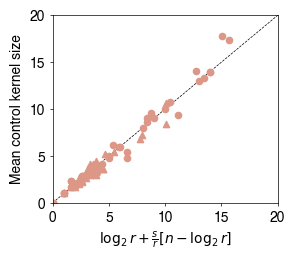

In [45]:
# plot actual ck size versus isolated approximation for cell collective networks

plt.figure(figsize=figsize)

# cell collective
for ck_func in [predict_ck_separate_isolated,]:
    plt.scatter(ck_df_Filtered[ck_func.__name__],
                ck_df_Filtered['mean control kernel size'],
                label=ck_func.__name__,
                s=markersize,
                c=colors1['cellcollective'])

# iowa database
for ck_func in [predict_ck_separate_isolated,]:
    plt.scatter(dfIowa_Filtered[ck_func.__name__],
                dfIowa_Filtered['mean control kernel size'],
                label=ck_func.__name__,
                s=markersize,
                c=colors1['cellcollective'],
                marker='^')

print("This plot includes points for {} cell collective networks.".format(ck_df_Filtered['predict_ck_separate_isolated'].count()))
print("This plot includes points for {} Iowa database networks.".format(dfIowa_Filtered['predict_ck_separate_isolated'].count()))

#plt.xlabel('$\\frac{r-s}{r} \log_2{r} + \\frac{s}{r} n$')
plt.xlabel('$\\log_2{r} + \\frac{s}{r} \\left[ n - \\log_2{r} \\right]$')
plt.ylabel('Mean control kernel size')
minsize,maxsize = 0,20
plt.plot([minsize,maxsize],[minsize,maxsize],'k--',lw=0.5,zorder=-10)
plt.axis(xmin=minsize,xmax=maxsize,ymin=minsize,ymax=maxsize)
plt.yticks([0,5,10,15,20])
plt.subplots_adjust(bottom=bottom,top=top,left=left,right=right)
#plt.legend()
makePretty()
plt.savefig('240219_actual_versus_predicted_mean_ck_size_cell_collective_networks.pdf')

### 2024/1/30 histograms grouped by network

In [46]:
core_only = True

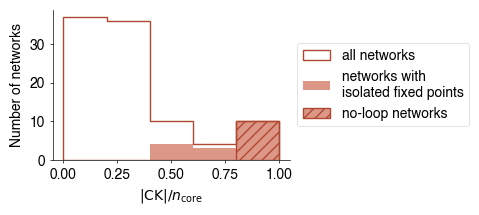

In [56]:
# isolated and non-isolated histograms grouped by networks (cell collective networks)
plt.figure(figsize=(5,2))

dfAllBio = pd.concat([ck_df,dfIowa])

if core_only:
    sizes = dfAllBio['number of core nodes']
else:
    sizes = dfAllBio['size']

bins = np.linspace(0,1,6)
plt.hist(dfAllBio['mean control kernel size']/sizes,
         histtype='step',
         bins=bins,
        density=False,
         color=colors1['cellcollective dark'],
         label='all networks',
        )
noloop_condition = dfAllBio['number of input nodes']==dfAllBio['number of core nodes']
isolated_condition = dfAllBio['number of isolated fixed points'] > 0
dfAllBio_noloop = dfAllBio[noloop_condition]
dfAllBio_with_isolated = dfAllBio[isolated_condition & (~noloop_condition)]
plt.hist(dfAllBio_with_isolated['mean control kernel size']/sizes,
        bins=bins,
        density=False,
        color=colors1['cellcollective'],
        label='networks with \nisolated fixed points')
plt.hist(dfAllBio_noloop['mean control kernel size']/sizes,
        bins=bins,
        density=False,
        color=colors1['cellcollective'],
        hatch='///',
        edgecolor=colors1['cellcollective dark'],
        label='no-loop networks')

# fiddle with main plot
leg = plt.legend(loc='center left',bbox_to_anchor=[1, 0.5])
#plt.yticks([0,2.5,5],[])
if core_only:
    plt.xlabel('$|\\mathrm{CK}|/n_{\\mathrm{core}}$')
else:
    plt.xlabel('$|\mathrm{CK}|/n$')
plt.ylabel('Number of networks')
plt.subplots_adjust(bottom=0.2,top=0.95,left=0.15,right=0.625)
plt.gca().spines[['right', 'top']].set_visible(False)
makePretty(leg=leg)
plt.savefig('240221_ck_histogram_by_network_isolated_and_nonisolated_all_bio.pdf')

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


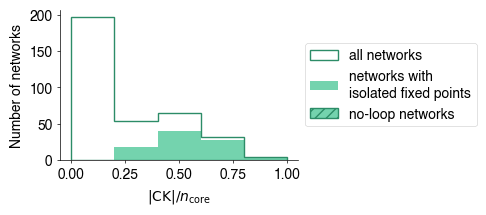

In [57]:
# isolated and non-isolated histograms grouped by networks (random networks)
plt.figure(figsize=(5,2))

if core_only:
    sizes = dfExactRandomAll['number of core nodes']
else:
    sizes = dfExactRandomAll['size']

bins = np.linspace(0,1,6)
plt.hist(dfExactRandomAll['mean control kernel size']/sizes,
         histtype='step',
         bins=bins,
        density=False,
        color=colors1['random dark'],
        label='all networks')
isolated_condition = dfExactRandomAll['number of isolated fixed points'] > 0
noloop_condition = dfExactRandomAll['number of core nodes'] == dfExactRandomAll['number of input nodes']
dfExactRandomAll_noloop = dfExactRandomAll[noloop_condition]
dfExactRandomAll_with_isolated = dfExactRandomAll[isolated_condition & (~noloop_condition)]
plt.hist(dfExactRandomAll_with_isolated['mean control kernel size']/sizes,
        bins=bins,
        density=False,
        color=colors1['random'],
        label='networks with \nisolated fixed points')
plt.hist(dfExactRandomAll_noloop['mean control kernel size']/sizes,
        bins=bins,
        density=False,
        color=colors1['random'],
        hatch='///',
        edgecolor=colors1['random dark'],
        label='no-loop networks')



# fiddle with main plot
leg = plt.legend(loc='center left',bbox_to_anchor=[1, 0.5])
#plt.yticks([0,2.5,5],[])
if core_only:
    plt.xlabel('$|\\mathrm{CK}|/n_{\\mathrm{core}}$')
else:
    plt.xlabel('$|\mathrm{CK}|/n$')
plt.ylabel('Number of networks')
plt.subplots_adjust(bottom=0.2,top=0.95,left=0.15,right=0.625)
plt.gca().spines[['right', 'top']].set_visible(False)
makePretty(leg=leg)
plt.savefig('240221_ck_histogram_by_network_isolated_and_nonisolated_random.pdf')

### Individual attractor plots

There are no networks without loops.


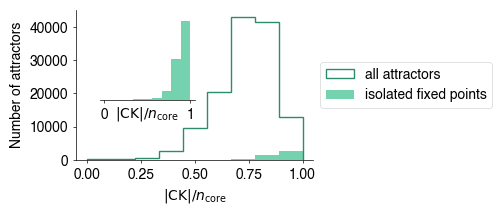

In [63]:
# isolated and non-isolated histograms for all random networks 
plt.figure(figsize=(5,2))

bins = np.linspace(0,1,10)
# plt.hist(relative_ck_sizes_nonisolated,density=False,bins=bins,histtype='step',label='non-isolated',
#          color=colors1['random dark'])

if core_only:
    all_relative_sizes = relative_ck_sizes_nonisolated_core_only + relative_ck_sizes_isolated_core_only + relative_ck_sizes_noloop_core_only
    isolated_relative_sizes = relative_ck_sizes_isolated_core_only
    noloop_relative_sizes = relative_ck_sizes_noloop_core_only
else:
    all_relative_sizes = relative_ck_sizes_nonisolated + relative_ck_sizes_isolated + relative_ck_sizes_noloop
    isolated_relative_sizes = relative_ck_sizes_isolated
    noloop_relative_sizes = relative_ck_sizes_noloop

plt.hist(all_relative_sizes,
         density=False,bins=bins,histtype='step',label='all attractors',
         color=colors1['random dark'])
plt.hist(isolated_relative_sizes,density=False,bins=bins,label='isolated fixed points',
         color=colors1['random'])
if len(noloop_relative_sizes) > 0:
    plt.hist(noloop_relative_sizes,density=False,bins=bins,label='isolated fixed points',
             color=colors1['random'])
else:
    print("There are no networks without loops.")

inset = plt.gca().inset_axes([0.1,0.4,0.4,0.55])
inset.hist(isolated_relative_sizes,density=False,bins=bins,label='isolated',
         color=colors1['random'])

# fiddle with main plot
leg = plt.legend(loc='center left',bbox_to_anchor=[1, 0.5])
#plt.yticks([0,2.5,5],[])
if core_only:
    xlabel = '$|\\mathrm{CK}|/n_{\\mathrm{core}}$'
else:
    xlabel = '$|\mathrm{CK}|/n$'
plt.xlabel(xlabel)
plt.ylabel('Number of attractors')
plt.subplots_adjust(bottom=0.2,top=0.95,left=0.15,right=0.625)
plt.gca().spines[['right', 'top']].set_visible(False)
makePretty(leg=leg)

# fiddle with inset
inset.spines[['right', 'top','left']].set_visible(False)
inset.set_yticks([])
inset.set_xlabel(xlabel,labelpad=-12)
makePretty(ax=inset)

plt.savefig('240221_ck_histogram_isolated_vs_nonisolated_random.pdf')

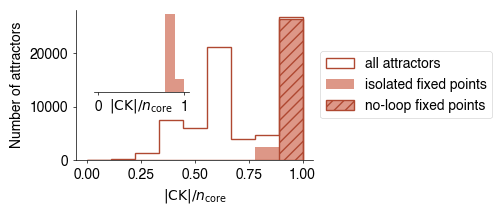

In [66]:
# isolated and non-isolated histograms for cell collective networks 
plt.figure(figsize=(5,2))

bins = np.linspace(0,1,10)
# plt.hist(relative_ck_sizes_nonisolated_cc,density=False,bins=bins,histtype='step',label='non-isolated',
#          color=colors1['cellcollective dark'])
if core_only:
    all_bio_all_relative_cks = relative_ck_sizes_nonisolated_core_only_cc+relative_ck_sizes_isolated_core_only_cc+\
                       relative_ck_sizes_nonisolated_core_only_iowa+relative_ck_sizes_isolated_core_only_iowa+\
                       relative_ck_sizes_noloop_core_only_cc+relative_ck_sizes_noloop_core_only_iowa
    all_bio_isolated_relative_cks = relative_ck_sizes_isolated_core_only_cc+relative_ck_sizes_isolated_core_only_iowa
    all_bio_noloop_relative_cks = relative_ck_sizes_noloop_core_only_cc+relative_ck_sizes_noloop_core_only_iowa
else:
    all_bio_all_relative_cks = relative_ck_sizes_nonisolated_cc+relative_ck_sizes_isolated_cc+\
                           relative_ck_sizes_nonisolated_iowa+relative_ck_sizes_isolated_iowa+\
                           relative_ck_sizes_noloop_cc+relative_ck_sizes_noloop_iowa
    all_bio_isolated_relative_cks = relative_ck_sizes_isolated_cc+relative_ck_sizes_isolated_iowa
    all_bio_noloop_relative_cks = relative_ck_sizes_noloop_cc+relative_ck_sizes_noloop_iowa
plt.hist(all_bio_all_relative_cks,
         density=False,bins=bins,histtype='step',label='all attractors',
         color=colors1['cellcollective dark'])
plt.hist(all_bio_isolated_relative_cks,density=False,bins=bins,label='isolated fixed points',
         color=colors1['cellcollective'])
plt.hist(all_bio_noloop_relative_cks,density=False,bins=bins,label='no-loop fixed points',
         color=colors1['cellcollective'],hatch='///',edgecolor=colors1['cellcollective dark'])

if core_only:
    inset = plt.gca().inset_axes([0.075,0.45,0.4,0.55])
else:
    inset = plt.gca().inset_axes([0.625,0.4,0.4,0.55])
inset.hist(all_bio_isolated_relative_cks,density=False,bins=bins,label='isolated',
         color=colors1['cellcollective'])

# fiddle with main plot
leg = plt.legend(loc='center left',bbox_to_anchor=[1, 0.5])
#plt.yticks([0,2.5,5],[])
if core_only:
    xlabel = '$|\\mathrm{CK}|/n_{\\mathrm{core}}$'
else:
    xlabel = '$|\mathrm{CK}|/n$'
plt.xlabel(xlabel)
plt.ylabel('Number of attractors')
plt.subplots_adjust(bottom=0.2,top=0.95,left=0.15,right=0.625)
plt.gca().spines[['right', 'top']].set_visible(False)
makePretty(leg=leg)

# fiddle with inset
inset.spines[['right', 'top','left']].set_visible(False)
inset.set_yticks([])
inset.set_xlabel(xlabel,labelpad=-12)
makePretty(ax=inset)

plt.savefig('240221_ck_histogram_isolated_vs_nonisolated_all_bio.pdf')

### 2024/1/30 are networks with isolated fixed points the only ones with maximal control kernels?

In [68]:
# 2024/1/30 do we only have maximal cks when there exist isolated fixed points?
# (2024/2/9 now using networks that have been filtered to remove those that are mostly uncontrollable)
random_with_isolated = dfExactRandomAll_Filtered[dfExactRandomAll_Filtered['proportion_of_isolated_fixed_points'] > 0].index

# count number of max ck attractors in each network
for name in dfExactRandomAll_Filtered.index: #dataDictExactRandom:
    if name in dataDictExactRandom:
        if 'control_kernel_sizes' in dataDictExactRandom[name]:
            net_size = dataDictExactRandom[name]['size']
            net_core_size = dfExactRandomAll.loc[name,'number of core nodes']
            num_max_cks = np.sum(np.array(dataDictExactRandom[name]['control_kernel_sizes']) == net_size)
            num_max_core_cks = np.sum(np.array(dataDictExactRandom[name]['control_kernel_sizes']) == net_core_size)
            dfExactRandomAll_Filtered.loc[name,'number_of_maximal_cks'] = num_max_cks
            dfExactRandomAll_Filtered.loc[name,'number_of_maximal_core_cks'] = num_max_core_cks
    elif name in dataDictExactRBN:
        if 'control_kernel_sizes' in dataDictExactRBN[name]:
            net_size = dataDictExactRBN[name]['size']
            net_core_size = dfExactRandomAll.loc[name,'number of core nodes']
            num_max_cks = np.sum(np.array(dataDictExactRBN[name]['control_kernel_sizes']) == net_size)
            num_max_core_cks = np.sum(np.array(dataDictExactRBN[name]['control_kernel_sizes']) == net_core_size)
            dfExactRandomAll_Filtered.loc[name,'number_of_maximal_cks'] = num_max_cks
            dfExactRandomAll_Filtered.loc[name,'number_of_maximal_core_cks'] = num_max_core_cks
    else:
        print("Network not found: {}".format(name))

# find networks with maximal cks
random_with_maximal = dfExactRandomAll_Filtered[dfExactRandomAll_Filtered['number_of_maximal_cks'] > 0].index
random_with_core_maximal = dfExactRandomAll_Filtered[dfExactRandomAll_Filtered['number_of_maximal_core_cks'] > 0].index

# compute intersection
print("{} filtered random networks with isolated fixed points, {} with maximal cks, {} with maximal core cks, {} with both.".format(
    len(random_with_isolated),
    len(random_with_maximal),
    len(random_with_core_maximal),
    len(random_with_isolated.intersection(random_with_maximal))))

87 filtered random networks with isolated fixed points, 73 with maximal cks, 73 with maximal core cks, 73 with both.


In [69]:
# 2024/1/30 do we only have maximal cks when there exist isolated fixed points?
cc_with_isolated = ck_df[ck_df['number of isolated fixed points'] > 0].index

# count number of max ck attractors in each network
for name in dataDictExact:
    if 'control_kernel_sizes' in dataDictExact[name]:
        net_size = dataDictExact[name]['size']
        net_core_size = ck_df.loc[nice_name(name),'number of core nodes']
        num_max_cks = np.sum(np.array(dataDictExact[name]['control_kernel_sizes']) == net_size)
        num_max_core_cks = np.sum(np.array(dataDictExact[name]['control_kernel_sizes']) == net_core_size)
        ck_df.loc[name,'number_of_maximal_cks'] = num_max_cks
        ck_df.loc[name,'number_of_maximal_core_cks'] = num_max_core_cks

# find networks with maximal cks
cc_with_maximal = ck_df[ck_df['number_of_maximal_cks'] > 0].index
cc_with_core_maximal = ck_df[ck_df['number_of_maximal_core_cks'] > 0].index

# compute intersection
print("{} cell collective networks with isolated fixed points, {} with maximal cks, {} with maximal core cks, {} with both.".format(
    len(cc_with_isolated),
    len(cc_with_maximal),
    len(cc_with_core_maximal),
    len(cc_with_isolated.intersection(cc_with_core_maximal))))

13 cell collective networks with isolated fixed points, 6 with maximal cks, 13 with maximal core cks, 13 with both.


In [70]:
# 2024/1/30 do we only have maximal cks when there exist isolated fixed points?
iowa_with_isolated = dfIowa[dfIowa['number of isolated fixed points'] > 0].index

# count number of max ck attractors in each network
for name in dataDictIowa:
    if 'control_kernel_sizes' in dataDictIowa[name]:
        num_max_cks = np.sum(np.array(dataDictIowa[name]['control_kernel_sizes']) == dataDictIowa[name]['size'])
        dfIowa.loc[name,'number_of_maximal_cks'] = num_max_cks

# find networks with maximal cks
iowa_with_maximal = dfIowa[dfIowa['number_of_maximal_cks'] > 0].index

# compute intersection
print("{} Iowa database networks with isolated fixed points, {} with maximal cks, {} with both.".format(
    len(iowa_with_isolated),
    len(iowa_with_maximal),
    len(iowa_with_isolated.intersection(iowa_with_maximal))))

4 Iowa database networks with isolated fixed points, 0 with maximal cks, 0 with both.


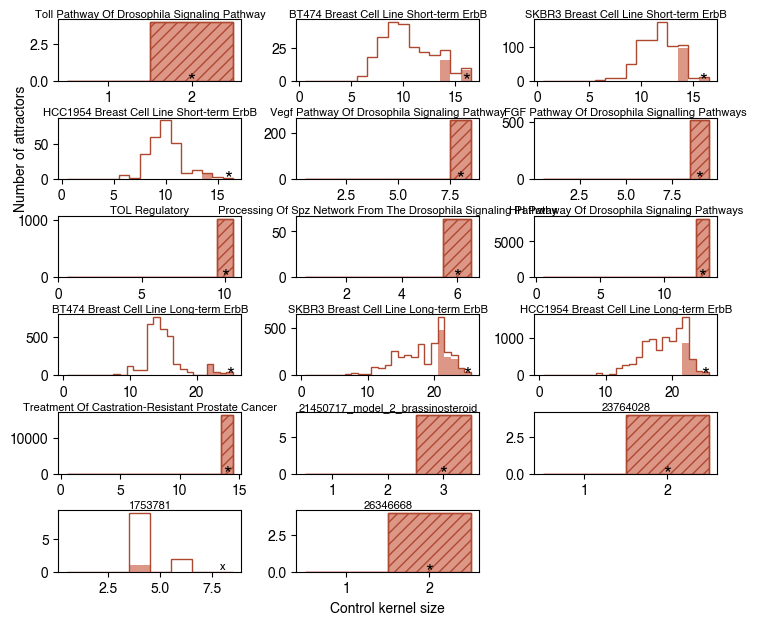

In [72]:
num_rows,num_cols = [9,3]
num_pages = len(random_with_isolated)//(num_rows*num_cols)+1
figsize=(8.5,11)

plt.figure(figsize=figsize)

# cell collective networks with isolated fixed points

for i,name in enumerate(cc_with_isolated):
    plt.subplot(num_rows,num_cols,i+1)
    if core_only:
        N = int(ck_df.loc[name,'number of core nodes'])
    else:
        N = ck_df.loc[name,'size']

    # hatching when network has no loops
    if ck_df.loc[name,'number of core nodes'] == ck_df.loc[name,'number of input nodes']:
        style = {'hatch':'///','edgecolor':colors1['cellcollective dark']}
    else:
        style = {}
        
    ck_sizes = basinDataDict[directory_name(name)]['control_kernel_sizes']
    is_isolated_list = basinDataDict[directory_name(name)]['is_isolated_list']
    bins = range(N+1)
    plt.hist(ck_sizes,bins=bins,histtype='step',
             color=colors1['cellcollective dark'],
             align='right')
    plt.hist([ ck_sizes[i] for i in range(len(ck_sizes)) if is_isolated_list[i] ],
             bins=bins,color=colors1['cellcollective'],
             align='right',**style)
    if i == num_cols: # put y-axis label on only one plot 
        plt.ylabel('Number of attractors')
    
    # add star or x at N
    xmin, xmax, ymin, ymax = plt.axis()
    if max([size for size in ck_sizes if size is not None]) == N:
        plt.text(N,0,'*',fontsize=15,ha='center',va='center')
    else:
        plt.text(N,0,'x',fontsize=8,ha='center',va='bottom')
    
    # plt.title('{},\n frac. uncontrollable = {}, num. cycles = {}, num. attractors = {}'.format(
                #     name,
                #     dfExactRandomAll.loc[name,'fraction of uncontrollable states'],
                #     dfExactRandomAll.loc[name,'number of cycles'],
                #     dfExactRandomAll.loc[name,'number of attractors']))
    if name.endswith(' Network'):
        title_name = name[:-8]
    else:
        title_name = name
    plt.title('{}'.format(
        title_name,
        ),fontsize=8,
        pad = 1)

# iowa networks with isolated fixed points
for i,name in enumerate(iowa_with_isolated):
    plt.subplot(num_rows,num_cols,i+len(cc_with_isolated)+1)
    if core_only:
        N = int(dfIowa.loc[name,'number of core nodes'])
    else:
        N = dfIowa.loc[name,'size']

    # hatching when network has no loops
    if dfIowa.loc[name,'number of core nodes'] == dfIowa.loc[name,'number of input nodes']:
        style = {'hatch':'///','edgecolor':colors1['cellcollective dark']}
    else:
        style = {}
    
    ck_sizes = basinDataExactIowa[name]['control_kernel_sizes']
    is_isolated_list = basinDataExactIowa[name]['is_isolated_list']
    bins = range(N+1)
    plt.hist(ck_sizes,bins=bins,histtype='step',
             color=colors1['cellcollective dark'],
             align='right')
    plt.hist([ ck_sizes[i] for i in range(len(ck_sizes)) if is_isolated_list[i] ],
             bins=bins,color=colors1['cellcollective'],
             align='right',**style)

    # add star or x at N
    xmin, xmax, ymin, ymax = plt.axis()
    if max([size for size in ck_sizes if size is not None]) == N:
        plt.text(N,0,'*',fontsize=15,ha='center',va='center')
    else:
        plt.text(N,0,'x',fontsize=8,ha='center',va='bottom')
    
    # plt.title('{},\n frac. uncontrollable = {}, num. cycles = {}, num. attractors = {}'.format(
                #     name,
                #     dfExactRandomAll.loc[name,'fraction of uncontrollable states'],
                #     dfExactRandomAll.loc[name,'number of cycles'],
                #     dfExactRandomAll.loc[name,'number of attractors']))
    if name.endswith(' Network'):
        title_name = name[:-8]
    else:
        title_name = name
    plt.title('{}'.format(
        title_name,
        ),fontsize=8,
        pad = 1)

# put x-axis label on only the last plot
plt.xlabel('Control kernel size')

# nicer xticks on last plot
if not core_only:
    plt.xticks([0,4,8])

plt.subplots_adjust(hspace=0.6,wspace=0.3)

plt.savefig('240221_individual_network_histograms_biological.pdf')

In [57]:
dfIowa['number of cycles'] = \
    dfIowa['number of attractors'] - dfIowa['number of fixed point attractors']
dfIowa['fraction of cycles'] = dfIowa['number of cycles']/dfIowa['number of attractors']

In [58]:
dfExactRandomAll['number of cycles'] = \
    dfExactRandomAll['number of attractors'] - dfExactRandomAll['number of fixed point attractors']
dfExactRandomAll['fraction of cycles'] = dfExactRandomAll['number of cycles']/dfExactRandom['number of attractors']

In [68]:
dfExactRandomAll['number of non-core nodes'] = dfExactRandomAll['size']-dfExactRandomAll['number of core nodes']

In [80]:
print("There are {} random networks that have both isolated fixed points and non-core nodes.".format(
    len(dfExactRandomAll[(dfExactRandomAll['number of isolated fixed points']>0) \
                       & (dfExactRandomAll['number of non-core nodes']>0)])))

There are 0 random networks that have both isolated fixed points and non-core nodes.


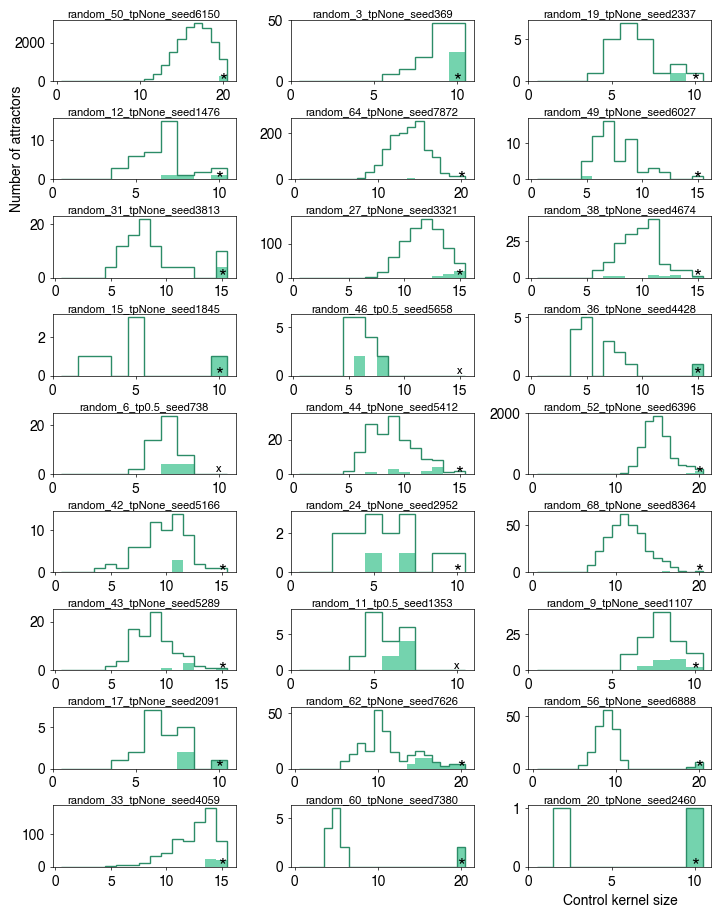

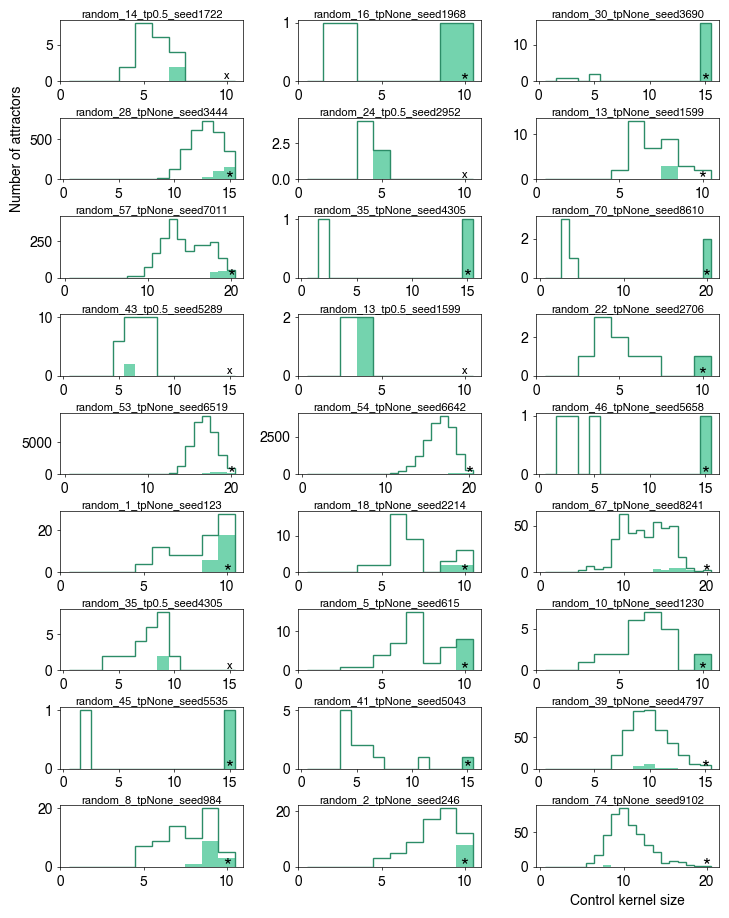

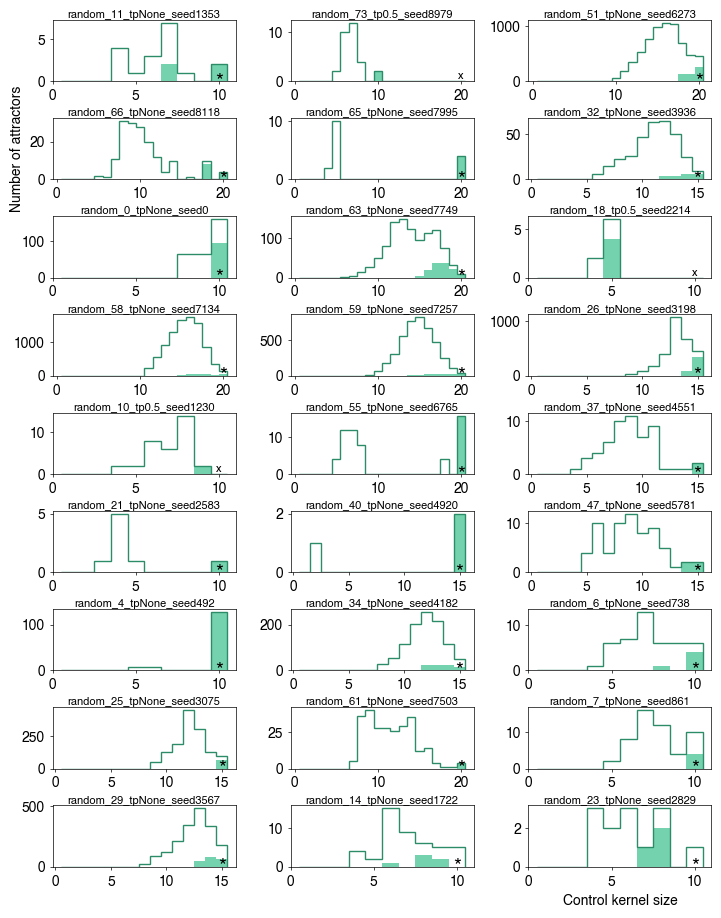

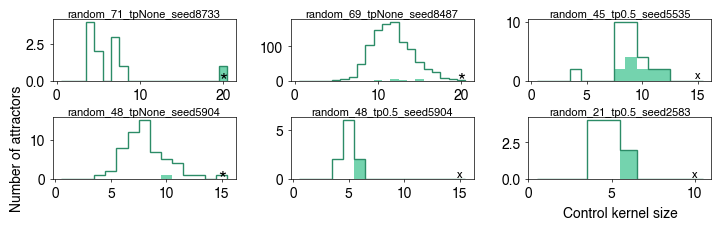

In [64]:
uncontrollable_threshold = np.inf
num_rows,num_cols = [9,3]
num_pages = len(random_with_isolated)//(num_rows*num_cols)+1
figsize=(8.5,11)

for page_index in range(num_pages):
    plt.figure(figsize=figsize)
    indices_on_page = range(page_index*num_rows*num_cols,
                            min((page_index+1)*num_rows*num_cols,
                                len(random_with_isolated)))
    for i,name in enumerate(random_with_isolated[indices_on_page]): 
        plt.subplot(num_rows,num_cols,i+1)
        if 'control_kernel_sizes_ordered' in basinDataExactRandom[name]:
            if dfExactRandomAll.loc[name,'fraction of uncontrollable states'] < uncontrollable_threshold:

                if core_only:
                    N = int(dfExactRandomAll.loc[name,'number of core nodes'])
                    is_isolated_list = basinDataExactRandom[name]['is_isolated_list_core_only_ordered']
                else:
                    N = dfExactRandomAll.loc[name,'size']
                    is_isolated_list = basinDataExactRandom[name]['is_isolated_list_ordered']
                ck_sizes = basinDataExactRandom[name]['control_kernel_sizes_ordered']
                
                #bins = range(max([size for size in ck_sizes if size is not None])+1)
                bins = range(N+1)
                plt.hist([ size for size in ck_sizes if size is not None ],
                         bins=bins,
                         histtype='step',
                         color=colors1['random dark'],
                         label='all controllable attractors',
                         align='right')
                plt.hist([ ck_sizes[i] for i in range(len(ck_sizes)) if is_isolated_list[i] ],
                         bins=bins,
                         color=colors1['random'],
                         label='isolated fixed points',
                         align='right')
    
                # add star or x at N
                xmin, xmax, ymin, ymax = plt.axis()
                if max([size for size in ck_sizes if size is not None]) == N:
                    plt.text(N,0,'*',fontsize=15,ha='center',va='center')
                else:
                    plt.text(N,0,'x',fontsize=8,ha='center',va='bottom')
                
                #leg = plt.legend()
                if i == num_cols: # put y-axis label on only one plot 
                    plt.ylabel('Number of attractors')
                # plt.title('{},\n frac. uncontrollable = {}, num. cycles = {}, num. attractors = {}'.format(
                #     name,
                #     dfExactRandomAll.loc[name,'fraction of uncontrollable states'],
                #     dfExactRandomAll.loc[name,'number of cycles'],
                #     dfExactRandomAll.loc[name,'number of attractors']))
                plt.title('{}'.format(
                    name,
                    ),fontsize=8,
                    pad = 1)
                makePretty()
            else:
                print("Uncontrollable basins are too large for network {}".format(name))
        else:
            print("No control kernel data for {}".format(name))
    
    # put x-axis label on only the last plot
    plt.xlabel('Control kernel size')

    plt.subplots_adjust(hspace=0.6,wspace=0.3)

    plt.savefig('240219_individual_network_histograms_random_{}.pdf'.format(page_index))

# other plots that were cut

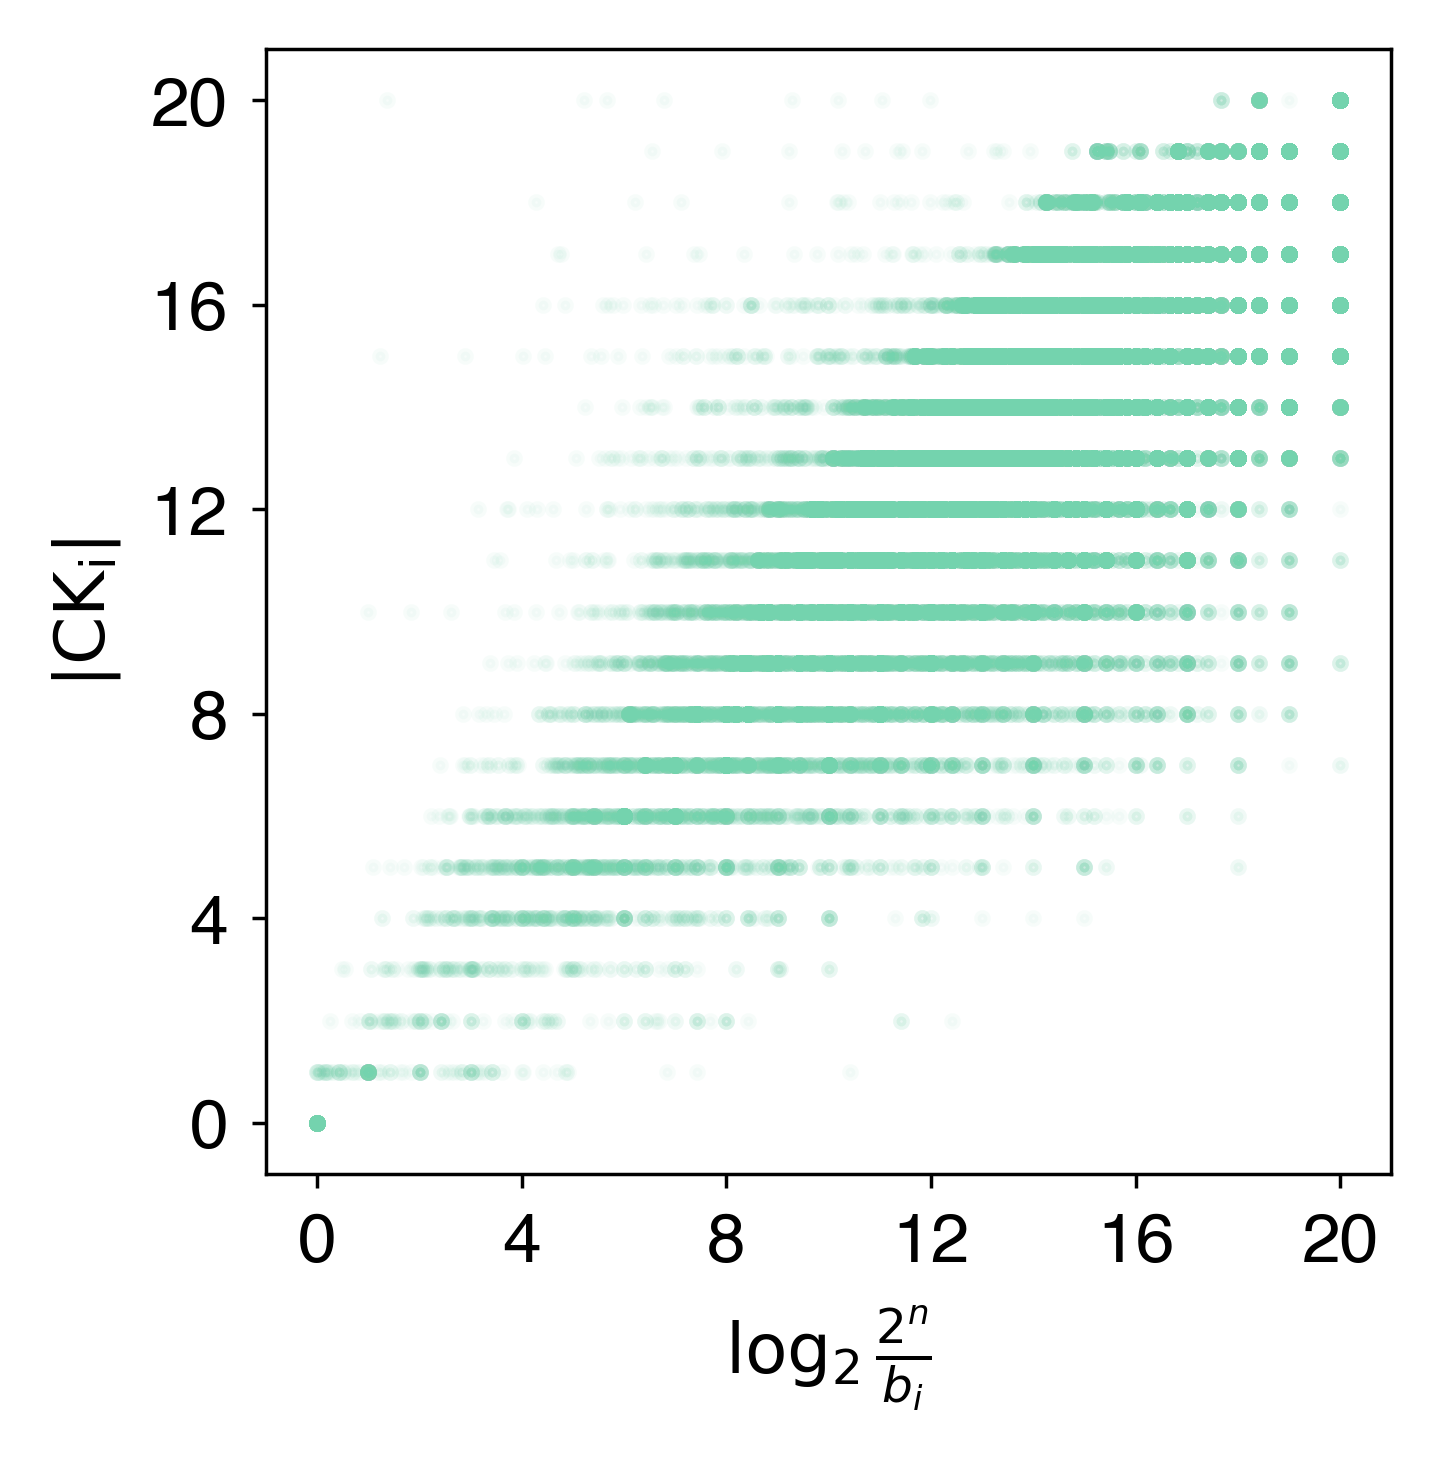

In [26]:
plt.figure(figsize=(3,3),dpi=500)
# plt.hist2d(np.log2(relative_basin_sizes)/net_sizes,
#            relative_ck_sizes,bins=10,cmap=plt.colormaps['RdYlBu']) #,alpha=0.05,s=10)
plt.scatter(-np.log2(relative_basin_sizes),
            absolute_ck_sizes,alpha=0.05,s=2,
            c=colors1['random'])
#plt.xscale('log')
plt.xlabel('$\\log_2{\\frac{2^n}{b_i}}$')
plt.ylabel('$|\mathrm{CK_i}|$')
plt.xticks(range(0,21,4))
plt.yticks(range(0,21,4))
plt.subplots_adjust(bottom=0.2,top=0.95,left=0.2,right=0.95)
makePretty()
plt.savefig('240130_ck_size_vs_relative_basin_size.png')

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


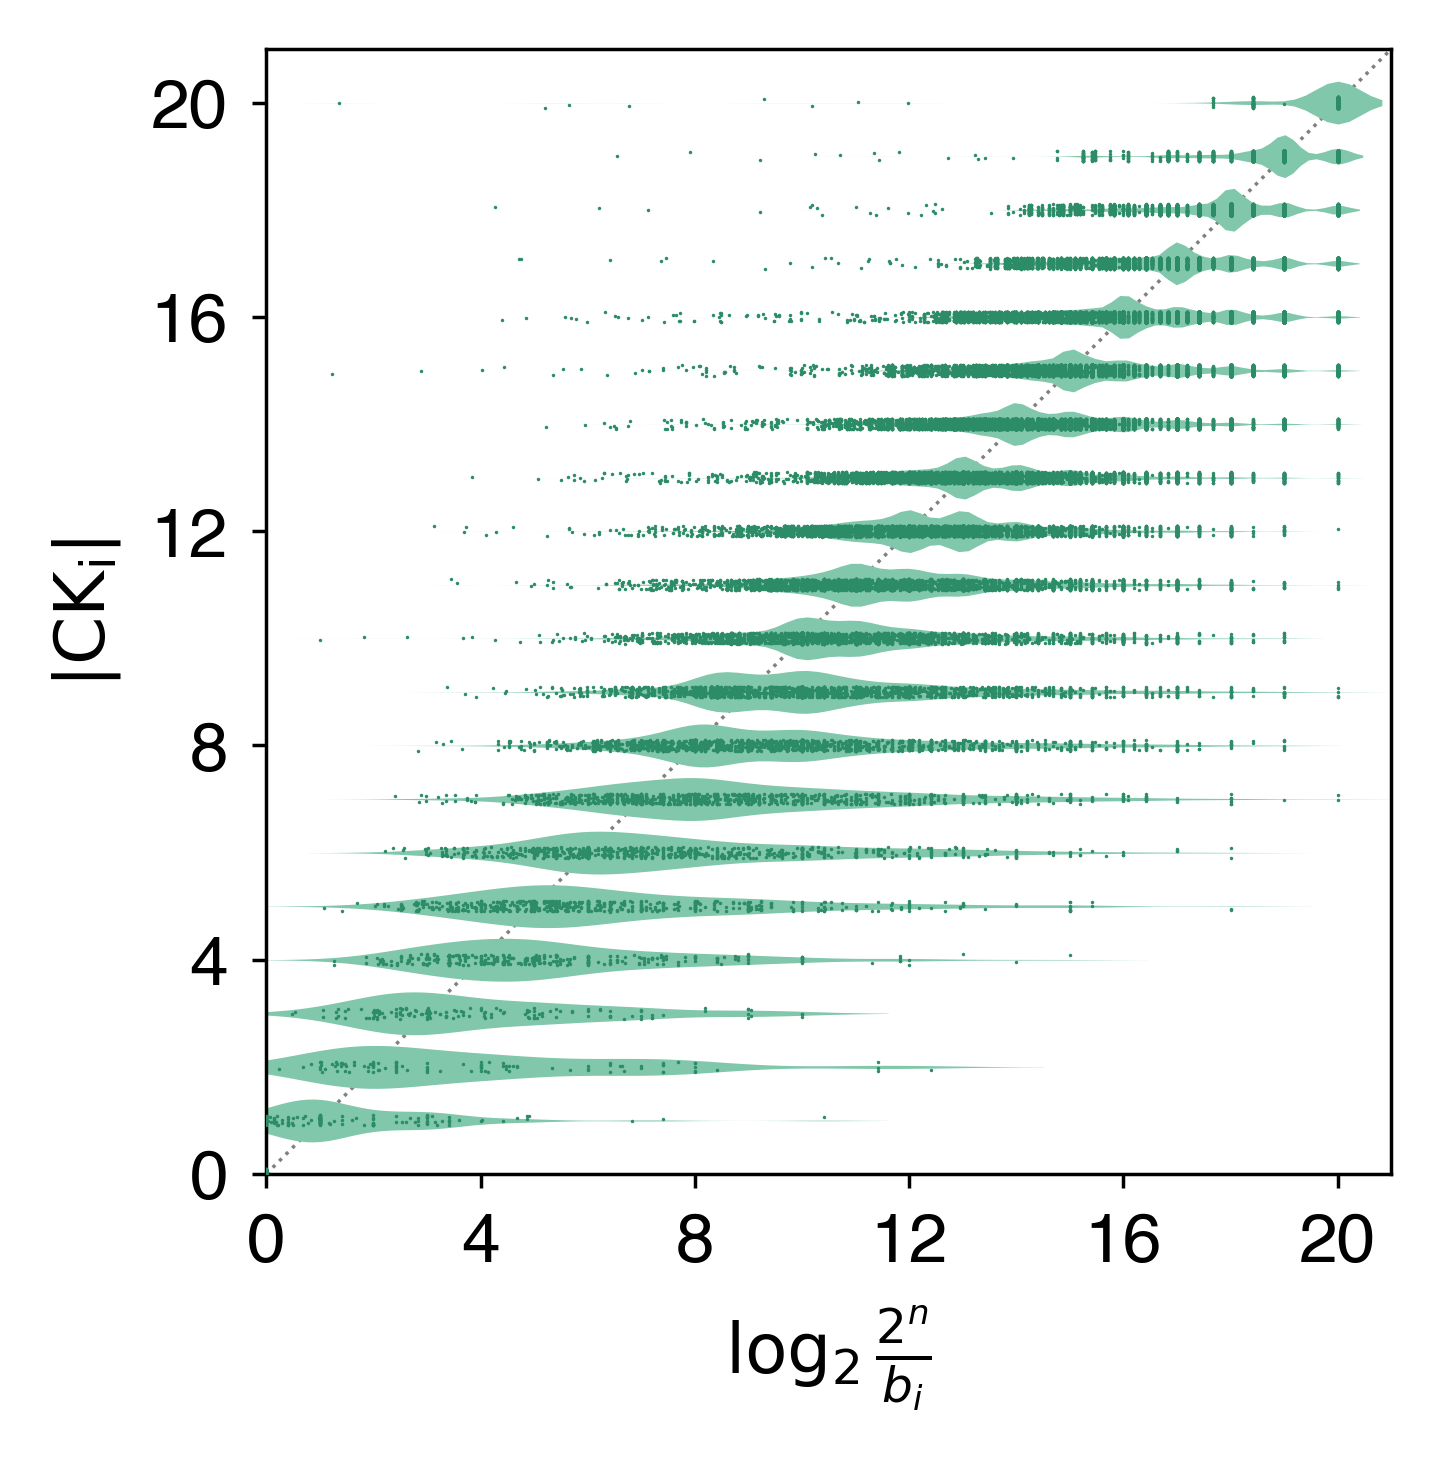

In [48]:
# make corresponding violin plot using seaborn

plotdata = pd.DataFrame(np.transpose([-np.log2(relative_basin_sizes),
                                      absolute_ck_sizes]),
                       columns=['log relative basin size','CK size float'])
plotdata['CK size'] = pd.cut(plotdata['CK size float'],bins=range(-1,21),labels=False).astype('str')
plotdata.sort_values(by='CK size float',inplace=True,ascending=True)

plt.figure(figsize=(3,3),dpi=500)
sb.violinplot(plotdata,
              x='log relative basin size',
              y='CK size',
              linewidth=0.0,
              scale='width', # in newer version of seaborn, this is density_norm='width'
              color=colors1['random']) 
sb.stripplot(plotdata,
              x='log relative basin size',
              y='CK size',
              size=0.5,
              color=colors1['random dark'])
plt.plot([0,21],[0,21],ls=':',lw=0.5,c='gray',zorder=-10)
plt.axis(xmin=0,xmax=21,ymin=0,ymax=21)
plt.xlabel('$\\log_2{\\frac{2^n}{b_i}}$')
plt.ylabel('$|\mathrm{CK_i}|$')
plt.xticks(range(0,21,4))
plt.yticks(range(0,21,4))
plt.subplots_adjust(bottom=0.2,top=0.95,left=0.2,right=0.95)
makePretty()
plt.savefig('240130_ck_size_vs_relative_basin_size_with_violin.png')

Text(0, 0.5, 'Number of maximal cks')

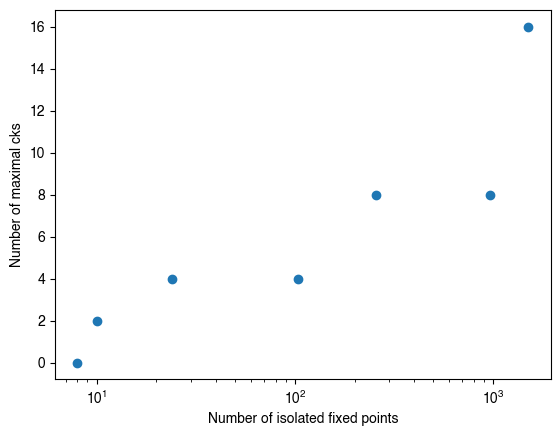

In [19]:
plt.scatter(ck_df['number of isolated fixed points'],
            ck_df['number_of_maximal_cks'])
plt.xscale('log')
plt.xlabel('Number of isolated fixed points')
plt.ylabel('Number of maximal cks')

Text(0, 0.5, 'Number of maximal cks')

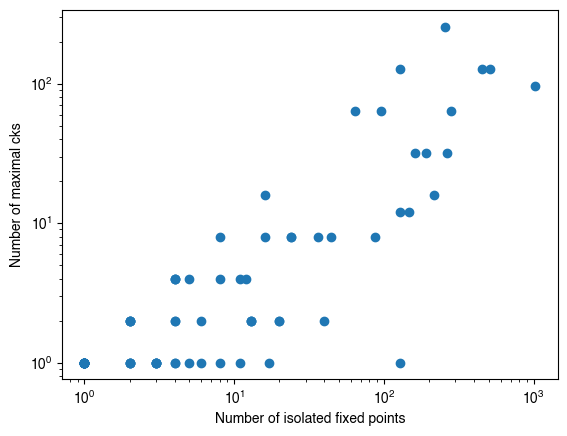

In [20]:
plt.scatter(dfExactRandomAll['number of isolated fixed points'],
            dfExactRandomAll['number_of_maximal_cks'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of isolated fixed points')
plt.ylabel('Number of maximal cks')

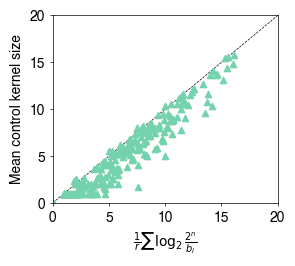

In [24]:
# plot actual ck size versus all-basin approximation for random networks

plt.figure(figsize=figsize)
for ck_func in [predict_ck_all_basins,]:
    plt.scatter(dfExactRandomAll[ck_func.__name__],
                dfExactRandomAll['mean control kernel size'],
                label=ck_func.__name__,
                s=markersize,
                c=colors1['random'],
                marker='^')

#plt.xlabel('$\\frac{r-s}{r} \log_2{r} + \\frac{s}{r} n$')
plt.xlabel('$\\frac{1}{r} \\sum \\log_2 \\frac{2^n}{b_i}$')
plt.ylabel('Mean control kernel size')
plt.plot([minsize,maxsize],[minsize,maxsize],'k--',lw=0.5,zorder=-10)
plt.axis(xmin=minsize,xmax=maxsize,ymin=minsize,ymax=maxsize)
plt.yticks([0,5,10,15,20])
plt.subplots_adjust(bottom=bottom,top=top,left=left,right=right)
#plt.legend()
makePretty()
plt.savefig('240130_actual_versus_predicted_mean_ck_size_all_basins_random_networks.pdf')

### 2024/1/31 modified controllability that neglects isolated fixed points

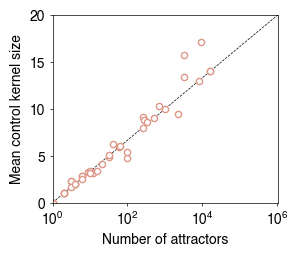

In [28]:
plt.figure(figsize=figsize)
plt.scatter(ck_df['number of attractors'],
            ck_df['mean control kernel size nonisolated'],
            s=markersize,
            label='Actual CK size',
            edgecolors=colors1['cellcollective'],
            c='w')

plt.xlabel('Number of attractors')
plt.ylabel('Mean control kernel size')
plt.xscale('log')
plt.plot([2**minsize,2**maxsize],[minsize,maxsize],'k--',lw=0.5,zorder=-10)
#plt.legend()
plt.axis(xmin=2**minsize,xmax=2**maxsize,ymin=minsize,ymax=maxsize)
plt.yticks([0,5,10,15,20])
plt.subplots_adjust(bottom=bottom,top=top,left=left,right=right)
makePretty()

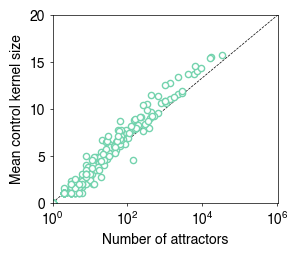

In [29]:
plt.figure(figsize=figsize)
plt.scatter(dfExactRandomAll['number of attractors'],
            dfExactRandomAll['mean control kernel size nonisolated'],
            s=markersize,
            label='Actual CK size',
            edgecolors=colors1['random'],
            c='w')

plt.xlabel('Number of attractors')
plt.ylabel('Mean control kernel size')
plt.xscale('log')
plt.plot([2**minsize,2**maxsize],[minsize,maxsize],'k--',lw=0.5,zorder=-10)
#plt.legend()
plt.axis(xmin=2**minsize,xmax=2**maxsize,ymin=minsize,ymax=maxsize)
plt.yticks([0,5,10,15,20])
plt.subplots_adjust(bottom=bottom,top=top,left=left,right=right)
makePretty()